# Introduction

This is a small subset of an analysis I have recently completed. The goal was to look at several different Machine Learning methods to predict statistics or awards for MLB baseball players. 

As you'll see, I chose to focus on predicting wOBA (weighted On Base Average) and a player's All-Star status. I take a pragmattic approach to the modeling by changing parameters, comparing different models, and using Feature Selection. 

The ultimate goal is to offer insight into my ability to explore a dataset and find "learnings". While this isn't incredibly valuable information (Who cares how accurately you can predict wOBA or if a player is an All-Star?), it showcases my thought processes and knowledge of how to apply Machine Learning to a problem. 

The data is from Sean Lahman's piblicly available baseball data. 

Source: http://www.seanlahman.com/baseball-archive/statistics/


**NOTE**
Please check back on my site () or GitHub page for future updates, as I will likely showcase additional exercises on this dataset. 

<br>
<br>
<br>

**Load Libraries and Set CWD**

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn import feature_selection
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn import naive_bayes, tree
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans 
from sklearn import metrics
from sklearn.metrics import completeness_score, homogeneity_score
from sklearn import decomposition
from sklearn import decomposition
from imblearn.over_sampling import RandomOverSampler



import warnings
warnings.filterwarnings('ignore')

 
os.chdir('E:\\DePaul Classes\\2019 - 2020\\2. Winter 2020\\DSC 540\\Project Datasets\\baseballdatabank-2019.2\\baseballdatabank-2019.2\\core')

<br>
<br>

**Load Datasets and Create Dataframe for Use**

In [3]:
#Load batting csv into df
batting = pd.read_csv('Batting.csv')

#Filter for only years 2000-2019
batting = batting.loc[(batting['yearID'] >= 2000) & (batting['yearID'] <= 2019)]


#Load player awards df
awards = pd.read_csv('AwardsPlayers.csv')

#Filter for only years 2000-2019
awards = awards.loc[(awards['yearID'] >= 2000) & (awards['yearID'] <= 2019)]



#Merge two DFs into one DF
df = pd.merge(batting, awards, on=['playerID', 'yearID'], how='outer')


#Drop stint, teamID, lgID_x, lgID_y, tie, and notes
df = df.drop(['stint', 'teamID', 'lgID_x', 'lgID_y', 'tie', 'notes'], axis=1)



##Create New Columns for All Star and MVP Awards (Yes or No)
df['allStar'] = ['Yes' if x == 'TSN All-Star' else 'No' for x in df['awardID']]
df['allStar'].value_counts()

df['mvp'] = ['Yes' if x == 'Most Valuable Player' else 'No' for x in df['awardID']]
df['mvp'].value_counts()

df = df.drop(['awardID'], axis = 1)
df.head()

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,...,CS,BB,SO,IBB,HBP,SH,SF,GIDP,allStar,mvp
0,abbotje01,2000,80.0,215.0,31.0,59.0,15.0,1.0,3.0,29.0,...,1.0,21.0,38.0,1.0,2.0,2.0,1.0,2.0,No,No
1,abbotku01,2000,79.0,157.0,22.0,34.0,7.0,1.0,6.0,12.0,...,1.0,14.0,51.0,2.0,1.0,0.0,1.0,2.0,No,No
2,abbotpa01,2000,35.0,5.0,1.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,No,No
3,abreubo01,2000,154.0,576.0,103.0,182.0,42.0,10.0,25.0,79.0,...,8.0,100.0,116.0,9.0,1.0,0.0,3.0,12.0,No,No
4,aceveju01,2000,62.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,No,No


In [4]:
df.shape

(27053, 21)

**DF now contains 28,621 players' batting data from the years 2000-2019. It is also paired with All-Star and MVP awards.**

**As you can see, this data set mainly covers boxscore stats. Let's exercise Feature Engineering and see if the presence of advanced stats will help with our predictions**

In [5]:
#BABIP
#I check for NaN and change to 0 (Division Error)

df['BABIP'] = (df['H'] - df['HR'])/(df['AB'] - df['SO'] - df['HR'] + df['SF'])

df['BABIP'].value_counts()
df['BABIP'].isna().sum()

df.BABIP.fillna(0, axis=0, inplace=True)

In [6]:
#OBP
#I check for NaN and change to 0 (Division Error)

df['OBP'] = (df['H'] + df['BB'] + df['HBP']) / (df['AB'] + df['BB'] + df['HBP'] + df['SF'])

df['OBP'].isna().sum()
df.OBP.fillna(0, axis=0, inplace=True)

In [7]:
#Need to create a field for Singles

df['1B'] = df['H'] - df['2B'] - df['3B'] - df['HR']
df['1B'].isna().sum()
df['1B'].fillna(0, axis=0, inplace=True)

In [8]:
#SLugging %
#I check for NaN and change to 0 (Division Error)

df['SLG'] = (df['1B'] + (2*df['2B']) + (3*df['3B']) + (4*df['HR'])) / df['AB']
df['SLG'].isna().sum()
df.SLG.fillna(0, axis=0, inplace=True)

In [9]:
#Batting Average
#I check for NaN and change to 0 (Division Error)

df['BA'] = df['H']/df['AB']
df['BA'].isna().sum()
df.BA.fillna(0, axis=0, inplace=True)

In [10]:
#On Base Plus Slugging (OPS)

df['OPS'] = df['OBP'] + df['SLG']

In [11]:
#Isolated Power (ISO)
#I check for NaN and change to 0 (Division Error)

df['ISO'] = (df['2B'] + (2*df['3B']) + (3*df['HR'])) / df['AB']
df['ISO'].isna().sum()
df.ISO.fillna(0, axis=0, inplace=True)

In [12]:
# Weighted On Base Average (wOBA)
#wOBA (Using 2019 weights for 2000-2019)
#I check for NaN and change to 0 (Division Error)

df['wOBA'] = ((.690 * df['BB']) + (.719 * df['HBP']) + (.870 * df['1B']) + (1.217*df['2B']) + (1.529*df['3B']) + (1.940*df['HR'])) / (df['AB'] + df['BB'] - df['IBB'] + df['SF'] + df['HBP'])
df['wOBA'].isna().sum()
df.wOBA.fillna(0, axis=0, inplace=True)

**Now to Check for Missing Values**

In [13]:
df[df.isnull().any(axis=1)]

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,...,allStar,mvp,BABIP,OBP,1B,SLG,BA,OPS,ISO,wOBA
27048,valenbo02,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,No,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27049,hemonro99,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,No,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27050,lasorto01,2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,No,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27051,carpech02,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,No,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27052,braunry01,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,No,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
#Drop the 5 players who have missing information

df.dropna(axis=0, inplace=True)

In [15]:
df[df.isnull().any(axis=1)]

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,...,allStar,mvp,BABIP,OBP,1B,SLG,BA,OPS,ISO,wOBA


**Double checking that data matched correctly. Miguel Cabrera and Buster Posey won MVPs in 2012**

In [16]:
df[(df['yearID'] == 2012) & (df['mvp'] == 'Yes')]

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,...,allStar,mvp,BABIP,OBP,1B,SLG,BA,OPS,ISO,wOBA
16859,cabremi01,2012,161.0,622.0,109.0,205.0,40.0,0.0,44.0,139.0,...,No,Yes,0.331276,0.393113,121.0,0.606109,0.329582,0.999223,0.276527,0.422069
17723,poseybu01,2012,148.0,530.0,78.0,178.0,39.0,1.0,24.0,103.0,...,No,Yes,0.367542,0.408197,114.0,0.549057,0.335849,0.957253,0.213208,0.404279


<br>
<br>

# Exploratory Data Analysis

In [17]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
playerID,27048,5364,rodrial01,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yearID,27048,NaN,NaN,NaN,2009.17,5.51499,2000,2004,2009,2014,2018
G,27048,NaN,NaN,NaN,50.8727,46.6836,1,14,33,74,163
AB,27048,NaN,NaN,NaN,124.127,185.588,0,0,18,186,716
R,27048,NaN,NaN,NaN,16.9003,28.3312,0,0,1,22,152
H,27048,NaN,NaN,NaN,32.6418,52.3952,0,0,3,46,262
2B,27048,NaN,NaN,NaN,6.51556,10.892,0,0,0,9,59
3B,27048,NaN,NaN,NaN,0.664929,1.58775,0,0,0,1,23
HR,27048,NaN,NaN,NaN,4.02459,8.30604,0,0,0,4,73
RBI,27048,NaN,NaN,NaN,16.2015,28.1429,0,0,1,20,160


**Some Visualizations**

Text(0.5, 1.0, 'Hits Distribution')

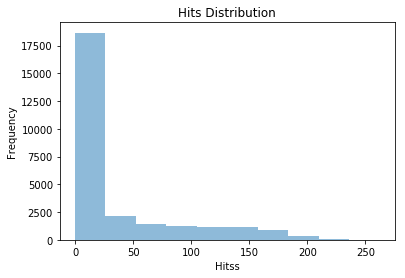

In [18]:
plt.hist(df['H'], bins=10, alpha=0.5)
plt.xlabel('Hitss')
plt.ylabel('Frequency')
plt.title('Hits Distribution')

Text(0.5, 1.0, 'Homerun Distribution')

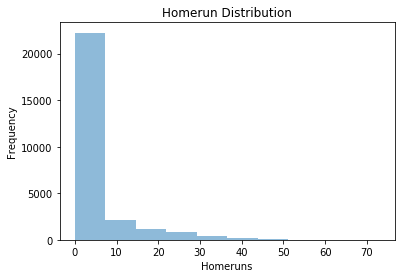

In [19]:
#Homeruns
plt.hist(df['HR'], bins=10, alpha=0.5)
plt.xlabel('Homeruns')
plt.ylabel('Frequency')
plt.title('Homerun Distribution')

Text(0.5, 1.0, 'On Base Plus Slugging % Distribution')

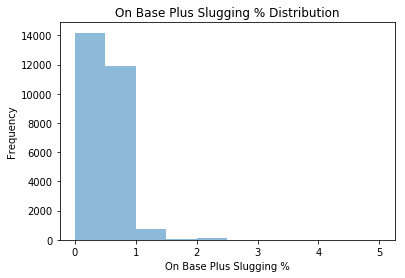

In [20]:
##OPS
plt.hist(df['OPS'], bins=10, alpha=0.5)
plt.xlabel('On Base Plus Slugging %')
plt.ylabel('Frequency')
plt.title('On Base Plus Slugging % Distribution')

Text(0.5, 1.0, 'Weighted On Base Average Distribution')

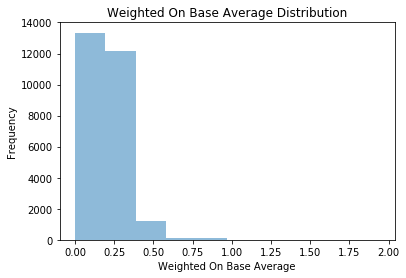

In [21]:
##wOBA
plt.hist(df['wOBA'], bins=10, alpha=0.5)
plt.xlabel('Weighted On Base Average')
plt.ylabel('Frequency')
plt.title('Weighted On Base Average Distribution')

**It's easy to see that the distribution of the data is skewed - which makes sense. There are many players that do not accumulate boxscore stats due to lack of playing time.**

**Let's filter the data to only look at players with at least 100 At-Bats in a season.**

In [22]:
df2 = df[df['AB'] >= 100]
df2.shape

(8746, 29)

In [23]:
df2.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
playerID,8746,1683,rodrial01,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yearID,8746,NaN,NaN,NaN,2008.96,5.48776,2000,2004,2009,2014,2018
G,8746,NaN,NaN,NaN,105.575,38.7184,24,72,108,142,163
AB,8746,NaN,NaN,NaN,352.753,167.537,100,197,341,506,716
R,8746,NaN,NaN,NaN,49.3912,30.0946,3,24,44,71,152
H,8746,NaN,NaN,NaN,95.082,51.6673,13,48,88,137,262
2B,8746,NaN,NaN,NaN,19.0772,11.4284,0,9,17,27,59
3B,8746,NaN,NaN,NaN,1.95266,2.28307,0,0,1,3,23
HR,8746,NaN,NaN,NaN,12.0015,10.8769,0,4,9,17,73
RBI,8746,NaN,NaN,NaN,47.562,31.3216,0,22,40.5,67,160


Text(0.5, 1.0, 'Hits Distribution')

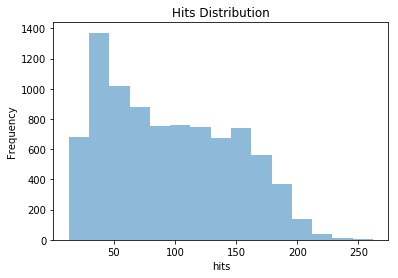

In [24]:
##Hits
plt.hist(df2['H'], bins=15, alpha=0.5)
plt.xlabel('hits')
plt.ylabel('Frequency')
plt.title('Hits Distribution')

Text(0.5, 1.0, 'Home Run Distribution')

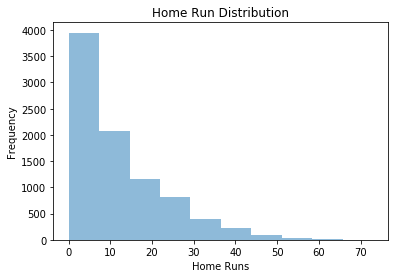

In [25]:
##HR
plt.hist(df2['HR'], bins=10, alpha=0.5)
plt.xlabel('Home Runs')
plt.ylabel('Frequency')
plt.title('Home Run Distribution')

Text(0.5, 1.0, 'On Base Plus Slugging % Distribution')

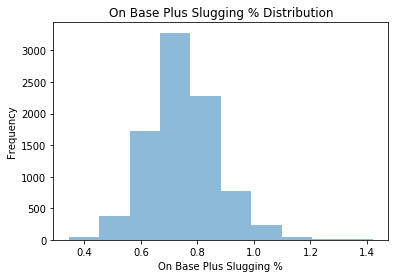

In [26]:
##OPS
plt.hist(df2['OPS'], bins=10, alpha=0.5)
plt.xlabel('On Base Plus Slugging %')
plt.ylabel('Frequency')
plt.title('On Base Plus Slugging % Distribution')

Text(0.5, 1.0, 'Weighted On Base Average Distribution')

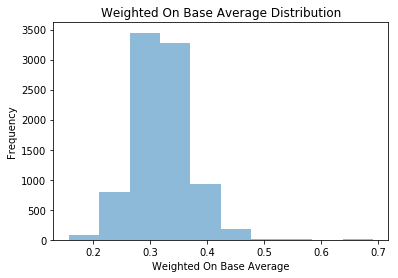

In [27]:
##wOBA
plt.hist(df2['wOBA'], bins=10, alpha=0.5)
plt.xlabel('Weighted On Base Average')
plt.ylabel('Frequency')
plt.title('Weighted On Base Average Distribution')

**Doing this led to some distributions becoming normal and in total, is more representative for the analysis that we are completing**

**Categorical Data Visualizations**

Text(0.5, 1.0, 'All Star Appearance Distribution')

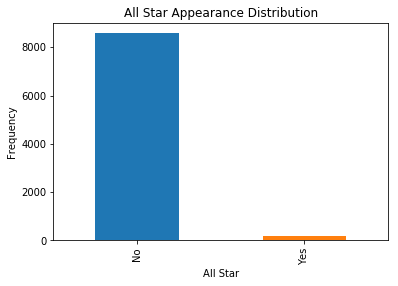

In [28]:
plot = df2['allStar'].value_counts().plot(kind='bar')
plot.set_xlabel('All Star')
plot.set_ylabel('Frequency')
plot.set_title('All Star Appearance Distribution')

Text(0.5, 1.0, 'Most Valuable Player Distribution')

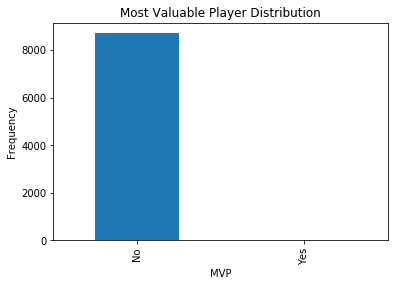

In [29]:
plot = df2['mvp'].value_counts().plot(kind='bar')
plot.set_xlabel('MVP')
plot.set_ylabel('Frequency')
plot.set_title('Most Valuable Player Distribution')

**Cross Tab ALL Star and MVP with Advanced Metrics wOBA, ISO, OPS**

Text(0.5, 1.0, 'wOBA: MVP vs No-MVP')

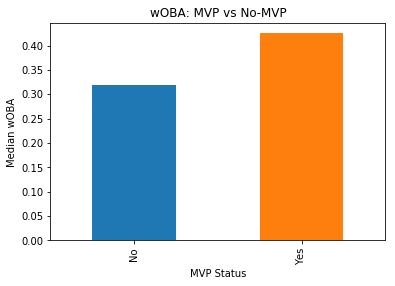

In [30]:
plot = df2.groupby('mvp')['wOBA'].median().plot.bar()
plot.set_xlabel('MVP Status')
plot.set_ylabel('Median wOBA')
plot.set_title('wOBA: MVP vs No-MVP')

On average, MVPs have a higher wOBA than non_MVP players. 

Text(0.5, 1.0, 'Isolated Power: MVP vs No-MVP')

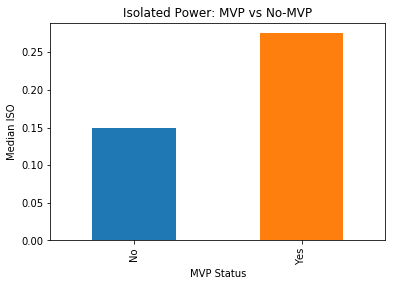

In [31]:
plot = df2.groupby('mvp')['ISO'].median().plot.bar()
plot.set_xlabel('MVP Status')
plot.set_ylabel('Median ISO')
plot.set_title('Isolated Power: MVP vs No-MVP')

On average, MVPs have a higher ISO than non_MVP players. 

Text(0.5, 1.0, 'On Base Plus Slugging: MVP vs No-MVP')

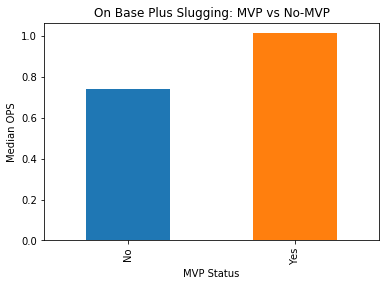

In [32]:
plot = df2.groupby('mvp')['OPS'].median().plot.bar()
plot.set_xlabel('MVP Status')
plot.set_ylabel('Median OPS')
plot.set_title('On Base Plus Slugging: MVP vs No-MVP')

On average, MVPs have a higher OPS than non_MVP players. 

<br>
<br>

# Regression Analyses to Predict wOBA

**Let's prep the data so it's ready for analysis**

In [33]:
#Drop playerID and yearID since they are not informative features

df3 = df2.drop(['playerID', 'yearID'], axis = 1)
df3.shape

(8746, 27)

In [34]:
#Create dummy variables for categorical features

batter_df = pd.get_dummies(df3, columns=['allStar', 'mvp'])
batter_df.columns

Index(['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO',
       'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'BABIP', 'OBP', '1B', 'SLG', 'BA',
       'OPS', 'ISO', 'wOBA', 'allStar_No', 'allStar_Yes', 'mvp_No', 'mvp_Yes'],
      dtype='object')

<br>

**Regression Analyses for wOBA Predictions**

In [35]:
#Train/Test Split - NOTE: No Need To Normalize for LinReg
x = batter_df.drop(['wOBA'], axis=1)
x.shape

y = batter_df[['wOBA']]
y.shape

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=92)

<br>

In [36]:
#LinReg with full feature set. Nothing done to optimize

linreg = LinearRegression()
linreg.fit(x_train, y_train)

pred = linreg.predict(x_test)
MAE = mean_absolute_error(y_test, pred)
print('The MAE on the test data is: ', MAE)

The MAE on the test data is:  0.0008358272468635857


MAE of ~0.001 wOBA is very good. This indicates that the data provided will do a very good job at predicting wOBA on players not in this dataset. 

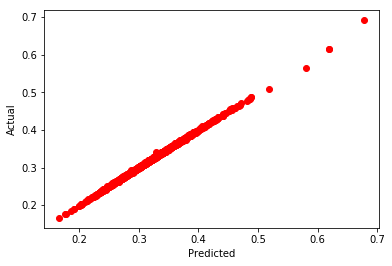

In [37]:
#Visualization of Actual vs Predicted

plt.plot(pred, y_test, 'ro')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<br>

In [38]:
#Let's try again, but with Feature Selection

linreg = LinearRegression()

percentiles = range(1, len(x.columns), 1)
results = []
for i in range(1, len(x.columns), 1):
    fs = feature_selection.SelectPercentile(feature_selection.f_regression, percentile=i)
    x_train_fs = fs.fit_transform(x_train, y_train)
    scores = abs(cross_val_score(linreg, x_train_fs, y_train, cv=5, scoring='neg_mean_absolute_error'))
    print("%2d  %0.4f" % (i, scores.mean()))
    results = np.append(results, scores.mean())

optimal_percentile_ind = np.where(results == results.min())[0][0]
print('Optimal Percentile Index: ', optimal_percentile_ind)

 1  0.0046
 2  0.0046
 3  0.0046
 4  0.0022
 5  0.0022
 6  0.0022
 7  0.0022
 8  0.0022
 9  0.0022
10  0.0022
11  0.0022
12  0.0019
13  0.0019
14  0.0019
15  0.0019
16  0.0019
17  0.0019
18  0.0019
19  0.0019
20  0.0019
21  0.0019
22  0.0019
23  0.0019
24  0.0019
25  0.0019
26  0.0019
27  0.0019
Optimal Percentile Index:  18


In [39]:
optimal_percentile_ind = np.where(results == results.min())[0][0]
print("Optimal percentile of features:{0}".format(percentiles[optimal_percentile_ind]), "\n")

Optimal percentile of features:19 



In [40]:
optimal_num_features = int(percentiles[optimal_percentile_ind]*len(x.columns)/100)
print("Optimal number of features:{0}".format(optimal_num_features), "\n")

Optimal number of features:5 



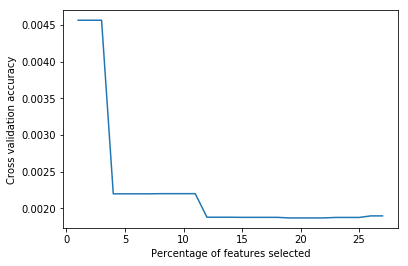

In [41]:
# Plot percentile of features VS. cross-validation scores
plt.figure()
plt.xlabel("Percentage of features selected")
plt.ylabel("Cross validation accuracy")
plt.plot(percentiles,results)

In [42]:
#Show us the features that are most important for predicting wOBA

fs = feature_selection.SelectPercentile(feature_selection.f_regression, percentile = 19)
x_train_fs = fs.fit_transform(x_train, y_train)

for i in range(len(x.columns.values)):
    if fs.get_support()[i]:
        print(x.columns.values[i],'\t', fs.scores_[i])

HR 	 7524.350912815796
OBP 	 39217.67142481077
SLG 	 48213.71729062954
BA 	 11438.834007658463
OPS 	 398276.28410386806
ISO 	 11471.08767993945


The results are not surprising. wOBA is another metric to valuate a player's ability to get on base. Home Runs, On Base Percentage, Slugging Percentage, Batting Average, On Base Plus Slugging Percentage, and Isolated Power are all metrics that capture much of the information that is the equation for wOBA. 

In [43]:
#Let's run the model now with the optimal number of features

fs = feature_selection.SelectKBest(feature_selection.f_regression, optimal_num_features)
x_train_fs = fs.fit_transform(x_train, y_train)
linreg.fit(x_train_fs, y_train)
x_test_fs = fs.transform(x_test)
pred = linreg.predict(x_test_fs)
MAE = mean_absolute_error(y_test, pred)

print('MAE of testing data is: ', MAE)

MAE of testing data is:  0.0018519452820427878


MAE is ~0.002, which is slightly lower than the full model without Feature Selection. However, I prefer this model to the one with all features because if we can use less features to get a better or similar result, this makes the model easierto explain to our team, leadership, or clients. 

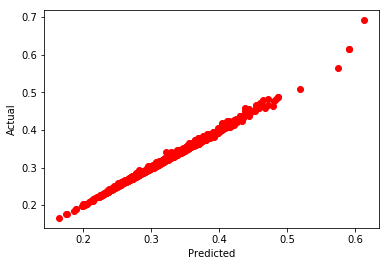

In [44]:
#Visualization

plt.plot(pred, y_test, 'ro')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<br>

**Now, I will run Ridge Regression, Lasso Regression, and SGR with Parameter Tuning**

In [45]:
#Function for finding best option for parameter of interest

def calc_params(X, y, clf, param_values, param_name, K):
    
    # Convert input to Numpy arrays
    X = np.array(X)
    y = np.array(y)

    # initialize training and testing score arrays with zeros
    train_scores = np.zeros(len(param_values))
    test_scores = np.zeros(len(param_values))
    
    # iterate over the different parameter values
    for i, param_value in enumerate(param_values):
        print(param_name, ' = ', param_value)
        
        # set classifier parameters
        clf.set_params(**{param_name:param_value})
        
        # initialize the K scores obtained for each fold
        k_train_scores = np.zeros(K)
        k_test_scores = np.zeros(K)
        
        # create KFold cross validation
        cv = KFold(n_splits=K, shuffle=True, random_state=0)
        
        # iterate over the K folds
        j = 0
        for train, test in cv.split(X):
            # fit the classifier in the corresponding fold
            # and obtain the corresponding accuracy scores on train and test sets
            clf.fit(X[train], y[train])
            k_train_scores[j] = clf.score(X[train], y[train])
            k_test_scores[j] = clf.score(X[test], y[test])
            j += 1
            
        # store the mean of the K fold scores
        train_scores[i] = np.mean(k_train_scores)
        test_scores[i] = np.mean(k_test_scores)
       
    # plot the training and testing scores in a log scale
    plt.plot(param_values, train_scores, label='Train', alpha=0.4, lw=2, c='b')
    plt.plot(param_values, test_scores, label='X-Val', alpha=0.4, lw=2, c='g')
    plt.legend(loc=7)
    plt.xlabel(param_name + " values")
    plt.ylabel("Mean cross validation accuracy")

    min_err_idx = np.where(test_scores == test_scores.min())
    min_err_alpha = param_values[min_err_idx]
    print('The minimum MAE using cross validation is:', test_scores[min_err_idx][0],'with', param_name,':', min_err_alpha[0])
    
    # return the training and testing scores on each parameter value
    return train_scores, test_scores

alpha  =  0.01
alpha  =  0.41795918367346935
alpha  =  0.8259183673469387
alpha  =  1.233877551020408
alpha  =  1.6418367346938774
alpha  =  2.0497959183673466
alpha  =  2.457755102040816
alpha  =  2.865714285714285
alpha  =  3.2736734693877545
alpha  =  3.681632653061224
alpha  =  4.0895918367346935
alpha  =  4.497551020408163
alpha  =  4.905510204081632
alpha  =  5.313469387755101
alpha  =  5.721428571428571
alpha  =  6.12938775510204
alpha  =  6.537346938775509
alpha  =  6.9453061224489785
alpha  =  7.353265306122448
alpha  =  7.761224489795917
alpha  =  8.169183673469387
alpha  =  8.577142857142857
alpha  =  8.985102040816326
alpha  =  9.393061224489795
alpha  =  9.801020408163264
alpha  =  10.208979591836734
alpha  =  10.616938775510203
alpha  =  11.024897959183672
alpha  =  11.432857142857141
alpha  =  11.84081632653061
alpha  =  12.24877551020408
alpha  =  12.65673469387755
alpha  =  13.064693877551019
alpha  =  13.472653061224488
alpha  =  13.880612244897957
alpha  =  14.288571

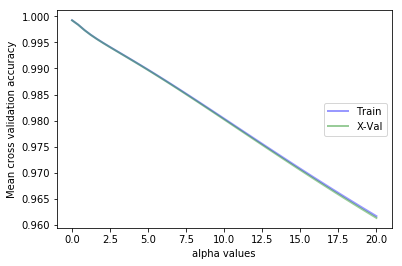

In [46]:
#Find Best Alpha for Ridge Regression

alpha = np.linspace(0.01, 20, 50)

ridge = Ridge(fit_intercept=True)

train_scores, test_scores = calc_params(x_train, y_train, ridge, alpha, 'alpha', 5)

As you can see, the alpha value of 20 produced the least amount of error. 

In [47]:
ridge = Ridge(fit_intercept = True, alpha = 20)
ridge.fit(x_train, y_train)

pred = ridge.predict(x_test)
MAE = mean_absolute_error(y_test, pred)
print('The MAE on the test data is :', MAE)

The MAE on the test data is : 0.005764400013398861


<br>

**Let's Do the Same, But for Lasso**

alpha  =  0.01
alpha  =  0.41795918367346935
alpha  =  0.8259183673469387
alpha  =  1.233877551020408
alpha  =  1.6418367346938774
alpha  =  2.0497959183673466
alpha  =  2.457755102040816
alpha  =  2.865714285714285
alpha  =  3.2736734693877545
alpha  =  3.681632653061224
alpha  =  4.0895918367346935
alpha  =  4.497551020408163
alpha  =  4.905510204081632
alpha  =  5.313469387755101
alpha  =  5.721428571428571
alpha  =  6.12938775510204
alpha  =  6.537346938775509
alpha  =  6.9453061224489785
alpha  =  7.353265306122448
alpha  =  7.761224489795917
alpha  =  8.169183673469387
alpha  =  8.577142857142857
alpha  =  8.985102040816326
alpha  =  9.393061224489795
alpha  =  9.801020408163264
alpha  =  10.208979591836734
alpha  =  10.616938775510203
alpha  =  11.024897959183672
alpha  =  11.432857142857141
alpha  =  11.84081632653061
alpha  =  12.24877551020408
alpha  =  12.65673469387755
alpha  =  13.064693877551019
alpha  =  13.472653061224488
alpha  =  13.880612244897957
alpha  =  14.288571

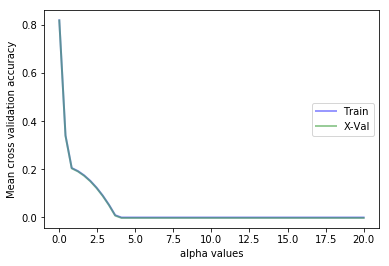

In [48]:
alpha = np.linspace(0.01, 20, 50)

lasso = Lasso(fit_intercept=True)

train_scores, test_scores = calc_params(x_train, y_train, lasso, alpha, 'alpha', 5)

As you can see from the output and the graph, the best alpha for minimizing error is ~ 4.09. 

In [49]:
lasso = Lasso(fit_intercept = True, alpha = 4.0895918367346935)
lasso.fit(x_train, y_train)

pred = lasso.predict(x_test)
MAE = mean_absolute_error(y_test, pred)
print('The MAE on the test data is :', MAE)

The MAE on the test data is : 0.03622433890775114


<br>

**Now, Let's Do SGD Regression with Grid Search**

In [50]:
# Standardize the data
scaler = StandardScaler()
scaler.fit(x)
x_scaled = scaler.transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.2, random_state = 92)

In [51]:
sgdreg = SGDRegressor()
parameters = {
    'penalty': ['l1','l2'],
    'alpha': np.linspace(0.0001, 200, 400)   
}

gs = GridSearchCV(sgdreg, parameters, verbose = 1, cv =5)


%time _ = gs.fit(x_train, y_train)

gs.best_params_, gs.best_score_

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Wall time: 45.5 s


[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:   45.3s finished


({'alpha': 0.0001, 'penalty': 'l1'}, 0.9986579871081316)

In [52]:
#Using the results, let's run a model

sgdreg = SGDRegressor(penalty = 'l2', alpha = 0.0001)
sgdreg.fit(x_train, y_train)
pred = sgdreg.predict(x_test)
MAE = mean_absolute_error(y_test, pred)

print('The MAE using Stochastic Gradient Descent on the test data is: ', MAE)

The MAE using Stochastic Gradient Descent on the test data is:  0.0011427590955420217


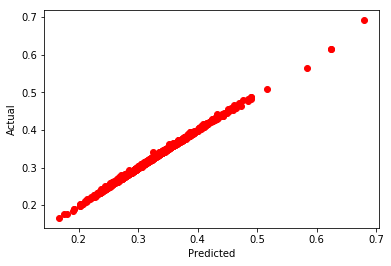

In [53]:
plt.plot(pred, y_test, 'ro')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<br>

**Overall Analysis**

Comparing the results of the different models' performance, SGD Regression performed very similarly to the Linear Regression model ran on the full feature set and with Feature Selection. The Ridge Regression model performed slightly worse when evaluating MAE and Lasso Regression was the worst performer of the group. 

It is important to try several approaches to this analysis and evaluate model performance. It's also important to keep interpretability in mind when choosing a model to move forward with. 

<br>
<br>

# KNN, Decision Tree, and Naive Bayes to Predict All-Stars

**Prep and Normalize Dataset**

In [54]:
x = df3.drop(['allStar'], axis=1)

y = df3[['allStar']]

#Get Dummies
x = pd.get_dummies(x, columns=['mvp'])

In [55]:
#Train/Test Split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=92)

In [56]:
#Normalize Data
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)

x_train_N = min_max_scaler.transform(x_train)
x_train_NormDF = pd.DataFrame(x_train_N, columns = x_train.columns, index=x_train.index)

x_test_N = min_max_scaler.transform(x_test)
x_test_NormDF = pd.DataFrame(x_test_N, columns = x_test.columns, index=x_test.index)

**Note:**

The target data (All-Star appearance) is imblanaced. You'll see that KNN has a difficult time with this. I used oversampling to improve results. 

<br>

**KNN**

In [57]:
# K = 5
n_neighbors = 5

knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(x_train_N, y_train)

knnpreds_test = knnclf.predict(x_test_N)
print(classification_report(y_test, knnpreds_test))

              precision    recall  f1-score   support

          No       0.98      0.98      0.98      1716
         Yes       0.00      0.00      0.00        34

   micro avg       0.97      0.97      0.97      1750
   macro avg       0.49      0.49      0.49      1750
weighted avg       0.96      0.97      0.96      1750



In [58]:
confusionMatrix = confusion_matrix(y_test, knnpreds_test)
print(confusionMatrix)

[[1689   27]
 [  34    0]]


In [59]:
tn, fp, fn, tp = confusion_matrix(y_test, knnpreds_test).ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
print('Sensitivity is: ', sensitivity)
print('Specificity is: ', specificity)

Sensitivity is:  0.0
Specificity is:  0.9842657342657343


In [60]:
print('Testing Data Accuracy', knnclf.score(x_test_N, y_test))
print('Training Data Accuracy', knnclf.score(x_train_N, y_train))

Testing Data Accuracy 0.9651428571428572
Training Data Accuracy 0.98642081189251


**This model is great at predicting if a player is NOT an All-Star and fails to correctly predict if a player IS an All-Star. But this isn't very helpful if the goal is to predict a player being an All-Star...Let's see if increasing the # of k helps.**

<br>

In [61]:
# K = 10
n_neighbors = 10

knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(x_train_N, y_train)
knnpreds_test = knnclf.predict(x_test_N)
print(classification_report(y_test, knnpreds_test))

              precision    recall  f1-score   support

          No       0.98      0.98      0.98      1716
         Yes       0.00      0.00      0.00        34

   micro avg       0.97      0.97      0.97      1750
   macro avg       0.49      0.49      0.49      1750
weighted avg       0.96      0.97      0.96      1750



In [62]:
confusionMatrix = confusion_matrix(y_test, knnpreds_test)
print(confusionMatrix)

[[1689   27]
 [  34    0]]


In [63]:
tn, fp, fn, tp = confusion_matrix(y_test, knnpreds_test).ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
print('Sensitivity is: ', sensitivity)
print('Specificity is: ', specificity)

Sensitivity is:  0.0
Specificity is:  0.9842657342657343


In [64]:
print('Testing Data Accuracy', knnclf.score(x_test_N, y_test))
print('Training Data Accuracy', knnclf.score(x_train_N, y_train))

Testing Data Accuracy 0.9651428571428572
Training Data Accuracy 0.98642081189251


**The results are identical. Since the target is so rare, we will need to oversample to help see if KNN can perform better.**

<br>

In [65]:
x_train.shape

(6996, 27)

In [71]:
#Get Dummies, Split Data, Oversample, and Normalize


#Train/Test Split - NOTE: No Need To Normalize for LinReg
x = df3.drop(['allStar'], axis=1)

y = df3[['allStar']]


#Get Dummies
x = pd.get_dummies(x, columns=['mvp'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=92)


#This is where we oversample
oversample = RandomOverSampler(sampling_strategy=0.5, random_state=92)
x_train, y_train = oversample.fit_resample(x_train, y_train)

#Normalize Data
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)

x_train_N = min_max_scaler.transform(x_train)

x_test_N = min_max_scaler.transform(x_test)

In [72]:
# K = 5
n_neighbors = 5

knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(x_train_N, y_train)
knnpreds_test = knnclf.predict(x_test_N)
print(classification_report(y_test, knnpreds_test))

              precision    recall  f1-score   support

          No       0.98      0.95      0.96      1716
         Yes       0.03      0.09      0.05        34

   micro avg       0.93      0.93      0.93      1750
   macro avg       0.51      0.52      0.50      1750
weighted avg       0.96      0.93      0.95      1750



In [73]:
confusionMatrix = confusion_matrix(y_test, knnpreds_test)
print(confusionMatrix)

[[1623   93]
 [  31    3]]


In [74]:
tn, fp, fn, tp = confusion_matrix(y_test, knnpreds_test).ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
print('Sensitivity is: ', sensitivity)
print('Specificity is: ', specificity)

Sensitivity is:  0.08823529411764706
Specificity is:  0.9458041958041958


In [75]:
print('Testing Data Accuracy', knnclf.score(x_test_N, y_test))
print('Training Data Accuracy', knnclf.score(x_train_N, y_train))

Testing Data Accuracy 0.9291428571428572
Training Data Accuracy 0.9871720116618076


**Woah! And just like that, the KNN model is better at predicting All-Stars when we oversample the data. Sensitivity and Specificity are of special interest here due to the class imbalance and we care a little less about Precision and Recall.**

<br>

In [76]:
# K = 10
n_neighbors = 10

knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(x_train_N, y_train)
knnpreds_test = knnclf.predict(x_test_N)
print(classification_report(y_test, knnpreds_test))

              precision    recall  f1-score   support

          No       0.98      0.93      0.96      1716
         Yes       0.03      0.12      0.05        34

   micro avg       0.91      0.91      0.91      1750
   macro avg       0.51      0.52      0.50      1750
weighted avg       0.96      0.91      0.94      1750



In [77]:
confusionMatrix = confusion_matrix(y_test, knnpreds_test)
print(confusionMatrix)

[[1597  119]
 [  30    4]]


In [78]:
tn, fp, fn, tp = confusion_matrix(y_test, knnpreds_test).ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
print('Sensitivity is: ', sensitivity)
print('Specificity is: ', specificity)

Sensitivity is:  0.11764705882352941
Specificity is:  0.9306526806526807


In [79]:
print('Testing Data Accuracy', knnclf.score(x_test_N, y_test))
print('Training Data Accuracy', knnclf.score(x_train_N, y_train))

Testing Data Accuracy 0.9148571428571428
Training Data Accuracy 0.9871720116618076


<br>

**Overall Analysis**

As you can see, using 10 neighbors performed just about the same as the model did when we used 5. However, the performance was better when using oversampling. Oversampling is a useful technique for dealing with a class imbalance and improving the performance of a model. Oversampling increased the model's ability to predict a player's All-Star status.

<br>

**Naive Bayes and Decision Tree Models**

I will use the oversampled and normalized data for this exercise.

In [80]:
#NB

nbclf = naive_bayes.GaussianNB()
nbclf = nbclf.fit(x_train, y_train)
nb_prediction_test = nbclf.predict(x_test)

print(classification_report(y_test, nb_prediction_test))

              precision    recall  f1-score   support

          No       1.00      0.79      0.88      1716
         Yes       0.08      0.94      0.15        34

   micro avg       0.80      0.80      0.80      1750
   macro avg       0.54      0.87      0.52      1750
weighted avg       0.98      0.80      0.87      1750



In [81]:
nb_confusionM = confusion_matrix(y_test, nb_prediction_test)
print(nb_confusionM)

[[1363  353]
 [   2   32]]


In [82]:
tn, fp, fn, tp = confusion_matrix(y_test, nb_prediction_test).ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
print('Sensitivity is: ', sensitivity)
print('Specificity is: ', specificity)

Sensitivity is:  0.9411764705882353
Specificity is:  0.7942890442890443


In [83]:
print('Score on Training: ', nbclf.score(x_train, y_train))
print('Score on Testing: ', nbclf.score(x_test, y_test))

Score on Training:  0.8659863945578231
Score on Testing:  0.7971428571428572


**The NB model does an exceptional job at correctly predicting All-Stars as All-Stars. It makes some False Positive predictions that ultimately drive down it's overall accuracy.**

<br>

In [84]:
#DT
#Entropy, Min Split = 4

treeclf = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 4)
treeclf = treeclf.fit(x_train, y_train)
tree_pred_test = treeclf.predict(x_test)
print(classification_report(y_test, tree_pred_test))

              precision    recall  f1-score   support

          No       0.98      0.96      0.97      1716
         Yes       0.03      0.06      0.04        34

   micro avg       0.94      0.94      0.94      1750
   macro avg       0.51      0.51      0.51      1750
weighted avg       0.96      0.94      0.95      1750



In [85]:
tree_confusionM = confusion_matrix(y_test, tree_pred_test)
print(tree_confusionM)

[[1650   66]
 [  32    2]]


In [86]:
tn, fp, fn, tp = confusion_matrix(y_test,tree_pred_test).ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
print('Sensitivity is: ', sensitivity)
print('Specificity is: ', specificity)

Sensitivity is:  0.058823529411764705
Specificity is:  0.9615384615384616


In [87]:
print('Testing Data Accuracy', treeclf.score(x_test, y_test))
print('Training Data Accuracy', treeclf.score(x_train, y_train))

Testing Data Accuracy 0.944
Training Data Accuracy 0.9871720116618076


**Performance is not as strong as the NB model when evaluating the Sensitivty and Specificity metrics. However, this DT model does a better job of not incorrectly predicting All-Stars.**

<br>

In [88]:
#DT
#Gini, Min Split = 4

treeclf = tree.DecisionTreeClassifier(criterion = 'gini', min_samples_split = 4)
treeclf = treeclf.fit(x_train, y_train)
tree_pred_test = treeclf.predict(x_test)
print(classification_report(y_test, tree_pred_test))

              precision    recall  f1-score   support

          No       0.98      0.96      0.97      1716
         Yes       0.04      0.09      0.06        34

   micro avg       0.95      0.95      0.95      1750
   macro avg       0.51      0.53      0.52      1750
weighted avg       0.96      0.95      0.95      1750



In [89]:
tree_confusionM = confusion_matrix(y_test, tree_pred_test)
print(tree_confusionM)

[[1651   65]
 [  31    3]]


In [90]:
tn, fp, fn, tp = confusion_matrix(y_test,tree_pred_test).ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
print('Sensitivity is: ', sensitivity)
print('Specificity is: ', specificity)

Sensitivity is:  0.08823529411764706
Specificity is:  0.9621212121212122


In [91]:
print('Testing Data Accuracy', treeclf.score(x_test, y_test))
print('Training Data Accuracy', treeclf.score(x_train, y_train))

Testing Data Accuracy 0.9451428571428572
Training Data Accuracy 0.9871720116618076


**DT with Gini as the criterion saw similar results to the DT model with Entropy as the criterion. Sensitivity and Specificity were the same, but the Gini model incorrectly predicted a few extra "fake" All-Stars.**

<br>

**Overall Analysis**

It turns out that it's very difficult to predict whether a player will be an All-Star or not based off their batting statistics. From a high level, this makes sense. All-Stars are voted in by fans and chosen by players and managers. To add to the complexity, there are only so many spots available and every year there are worthy players left off the teams. 

If we wanted to move forward with one of these models, I would recommend the Naive Bayes model simply due to the higher Sensitivity score. However, I wouldn't want to use any of these models if my job was on the line. I'd prefer to add new data and continue to work on finding a model that can do a better job with the Sensitivity and Specificity scores. 